Hi Malcolm,

This is a good idea. You may consider all NOAA climate indices (Chao can tell you where to get these) as the predictors from 1950 onward. We may need to figure out how to get the predictors before 1950. For example CRU (https://crudata.uea.ac.uk/cru/data/hrg/) for SST related indices, and the 20th Century Reanalysis (20CR) for circulation related indices (https://psl.noaa.gov/data/20thC_Rean/ or https://portal.nersc.gov/project/20C_Reanalysis/)

Best regards,
Liang

Dear Malcolm,
Yes! NOAA has provided a range of circulation indicators, and their raw data can be accessed at https://psl.noaa.gov/data/climateindices/list/. Additionally, I have already processed some of these indicators and organized them into a tidy format, which can be found at https://github.com/sunchaoatmo/ML_course/blob/master/climateindex_mon_1979_2019.xlsx.


Best regards,
Chao Sun

Thoughts...

- Predict tornadoes in year from the index values in jan of that year?
- Or december of last year? Probably more scientifically proper
- Predict tornadoes in month from indices in previous month? This is probably not as useful because you can kinda just run climate models
- Predict, for example, the number of tornadoes in May based on index values in jan, feb, mar?

In [1]:
# create clean df with climate indices
import numpy as np
import pandas as pd
import os

indices = []
for fname in os.listdir('indices'):
#     print(fname, end='\r')
    df = pd.read_csv('indices/'+fname,
                     delim_whitespace=True, header=None)
    df = df.set_index(df[0])
    df.index.names = ['Year']
    prev_december = df.shift()[12]
    prev_december.name = fname[:fname.index('.data.txt')]
    indices.append(prev_december)
#     print(prev_december)

# indices

full_df = pd.concat(indices, axis=1).sort_index()
full_df = full_df[full_df.index >= 1875]
full_df = full_df[full_df.index <= 2022]
full_df = full_df.replace(-99, np.nan)
full_df

dmi.had.long  nao.long   np.long  pdo.long  pna.20crv2c.long  \
Year                                                                 
1875        -0.790     -2.12       NaN       NaN            -0.078   
1876        -0.460      0.08       NaN       NaN            -0.501   
1877        -0.297     -1.13       NaN       NaN             0.715   
1878         0.154      2.16       NaN       NaN             1.659   
1879        -0.470     -3.31       NaN       NaN             0.834   
...            ...       ...       ...       ...               ...   
2018         0.109      1.00  1009.667      0.50               NaN   
2019         0.309      1.93  1007.649      0.52               NaN   
2020         0.243      0.74  1007.804      0.97               NaN   
2021         0.030     -0.78  1003.435     -0.90               NaN   
2022        -0.120       NaN  1016.391     -2.00               NaN   

      sam.20crv2c.long  soi.long  tpi.long  tpi.timeseries.ersstv5.filt  
Year                                                                     
1875             0.183      1.28    -1.227                       -0.613  
1876            -0.195     -0.54    -0.974                       -0.479  
1877            -2.403     -0.45    -0.049                       -0.343  
1878             0.058     -1.52     1.724                       -0.236  
1879            -1.140      1.89    -0.334                       -0.175  
...                ...       ...       ...                          ...  
2018               NaN     -0.27    -1.067                          NaN  
2019               NaN      0.93     0.123                          NaN  
2020               NaN     -0.73    -0.071                          NaN  
2021               NaN      1.76    -1.263                          NaN  
2022               NaN      1.43       NaN                          NaN  

[148 rows x 9 columns]

In [18]:
# Get yearly tornado counts
import json
from itertools import groupby

with open('tornadoes.json', 'r') as f:
    tornadoes = json.load(f)

tornadoes = [tor for tor in tornadoes['features']
            if 'US' in tor['properties']['countries']
            and int(tor['properties']['datetime-start'][:4]) >= 1875]

intense_tors = []
for tor in tornadoes:
    rating = 0
    if type(tor['properties']['f-scale']) == list:
        rating = int(tor['properties']['f-scale'][0])
    else:
        rating = int(tor['properties']['f-scale'])
    
    if rating >= 3:
        intense_tors.append(tor)

intense_tor_years = [int(tor['properties']['datetime-start'][:4]) for tor in intense_tors]
count_dups = [sum(1 for x in group) for x, group in groupby(intense_tor_years)]
tor_series = pd.Series(data=count_dups, index=list(set(intense_tor_years)))

In [13]:
# get yearly tornado day counts
import json
from itertools import groupby
import pandas as pd

with open('tornadoes.json', 'r') as f:
    tornadoes = json.load(f)

tornadoes = [tor for tor in tornadoes['features']
            if 'US' in tor['properties']['countries']
            and int(tor['properties']['datetime-start'][:4]) >= 1875
            ]

intense_tors = []
for tor in tornadoes:
    rating = 0
    if type(tor['properties']['f-scale']) == list:
        rating = int(tor['properties']['f-scale'][0])
    else:
        rating = int(tor['properties']['f-scale'])
    
    if rating >= 3:
        intense_tors.append(tor)

intense_tors_central = []
for tor in intense_tors:
    if 'coordinates' in tor['geometry']:
        if tor['geometry']['type'] == 'Point':
            lon = int(tor['geometry']['coordinates'][0])
        else:
            lon = int(tor['geometry']['coordinates'][0][0])
    else:
        lon = int(tor['geometry']['geometries'][0]['coordinates'][0][0])
    
    if lon > -106 and lon < -90:
        intense_tors_central.append(tor)
    
# intense_tors_central

intense_tor_days = list(set([tor['properties']['datetime-start'][:10] for tor in intense_tors_central]))
intense_tor_days = sorted(intense_tor_days)

yearly_itds = [sum(1 for x in group) for x, group in groupby(intense_tor_days, key=lambda x: x[:4])]
years = [int(x) for x, group in groupby(intense_tor_days, key=lambda x: x[:4])]
tor_series = pd.Series(data=yearly_itds, index=years)
tor_series

1875     3
1876     5
1877     6
1878     8
1879     9
        ..
2018     7
2019    15
2020     4
2021     3
2022    11
Length: 148, dtype: int64

In [1]:
import json
from itertools import groupby
import pandas as pd

with open('tornadoes.json', 'r') as f:
    tornadoes = json.load(f)

tornadoes = [tor for tor in tornadoes['features']
            if 'US' in tor['properties']['countries']
            and int(tor['properties']['datetime-start'][:4]) >= 1875
            ]

tors_by_cat = [[], [], [], [], [], []]
for tor in tornadoes:
    rating = 0
    if type(tor['properties']['f-scale']) == list:
        rating = int(tor['properties']['f-scale'][0])
    else:
        rating = int(tor['properties']['f-scale'])
    
    if rating >= 0:
        tors_by_cat[rating].append(tor)

intense_tors_central = [[], [], [], [], [], []]
for i, category in enumerate(tors_by_cat):
    for tor in category:
        if 'coordinates' in tor['geometry']:
            if tor['geometry']['type'] == 'Point':
                lon = int(tor['geometry']['coordinates'][0])
            else:
                lon = int(tor['geometry']['coordinates'][0][0])
        else:
            lon = int(tor['geometry']['geometries'][0]['coordinates'][0][0])

        if lon > -106 and lon < -90:
            intense_tors_central[i].append(tor)

intense_tors_central

# intense_tor_days = list(set([tor['properties']['datetime-start'][:10] for tor in intense_tors_central]))
# intense_tor_days = sorted(intense_tor_days)

# yearly_itds = [sum(1 for x in group) for x, group in groupby(intense_tor_days, key=lambda x: x[:4])]
# years = [int(x) for x, group in groupby(intense_tor_days, key=lambda x: x[:4])]
# tor_series = pd.Series(data=yearly_itds, index=years)
# tor_series

[[{'type': 'Feature',
   'geometry': {'type': 'LineString',
    'coordinates': [[-95.18, 29.6], [-95.17, 29.6]]},
   'properties': {'datetime-start': '1943-07-09T01:30:00Z',
    'id': 'TPG6258',
    'f-scale': 0,
    'scale': 'F',
    'source': ['TPG'],
    'location': 'Galveston Road/ SW Houston, TX',
    'path-length': 0.6,
    'fatalities': 1,
    'injuries': 0,
    'states': ['TX'],
    'countries': ['US']}},
  {'type': 'Feature',
   'geometry': {'type': 'Point', 'coordinates': [-92.25, 31.75]},
   'properties': {'datetime-start': '1950-05-01T17:30:00Z',
    'path-length': 1,
    'path-width': 100,
    'fatalities': 0,
    'injuries': 0,
    'f-scale': 0,
    'scale': 'F',
    'source': ['SPC', 'NCEI'],
    'id': 'SPC70_NCEI10032643',
    'states': ['LA'],
    'countries': ['US']}},
  {'type': 'Feature',
   'geometry': {'type': 'Point', 'coordinates': [-98.3, 39.85]},
   'properties': {'datetime-start': '1950-05-19T01:00:00Z',
    'path-length': 0.1,
    'path-width': 10,
    'fata

Text(0, 0.5, 'SOI')

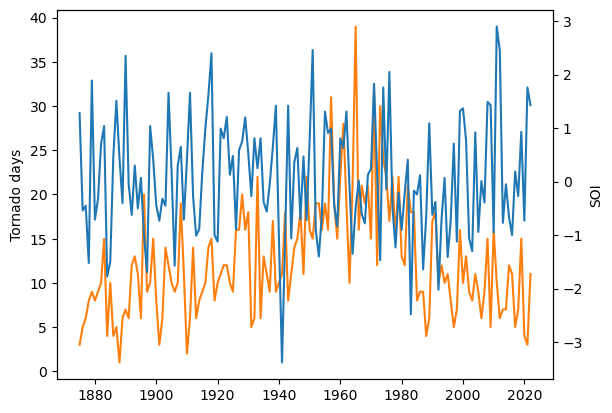

In [14]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()

ax1.plot(tor_series, 'tab:orange')
ax1.set_ylabel('Tornado days')
ax2 = ax1.twinx()
ax2.plot(full_df['soi.long'].to_frame(), 'tab:blue')
ax2.set_ylabel('SOI')

In [7]:
tor_series.index

Index(['1875', '1876', '1877', '1878', '1879', '1880', '1881', '1882', '1883',
       '1884',
       ...
       '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021',
       '2022'],
      dtype='object', length=148)

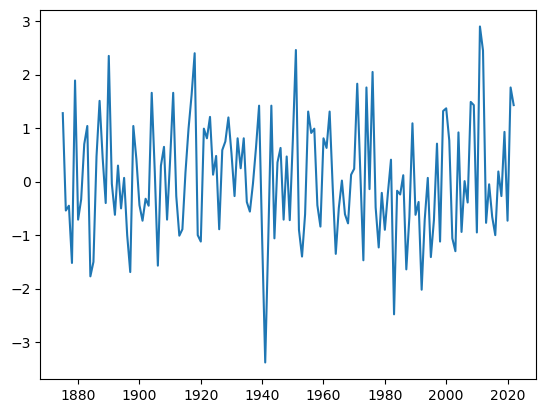

In [20]:
plt.plot(full_df['soi.long'].to_frame())

0.8295454545454546
0.03333333333333333


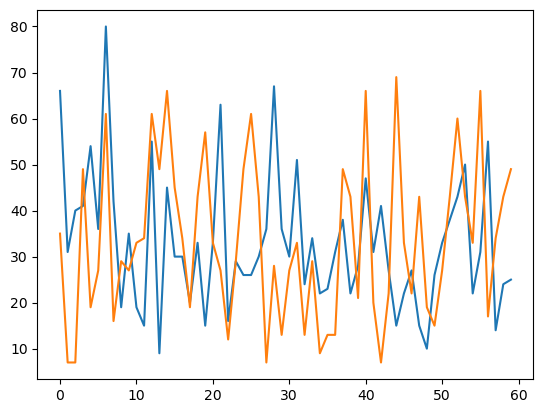

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

X = full_df['soi.long'].to_frame()
y = tor_series
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

regr = RandomForestClassifier(
#     n_estimators=10,
#     max_depth=5,
#     min_samples_split=7,
#     max_leaf_nodes=5,
)
regr.fit(X_train, y_train)
y_pred = pd.Series(data=regr.predict(X_test), index=X_test.index)
print(regr.score(X_train, y_train))
print(regr.score(X_test, y_test))
plt.plot(y_test.values, c='tab:blue')
plt.plot(y_pred.values, c='tab:orange')
# plt.plot(y_train.values, c='tab:blue')
# plt.plot(pd.Series(data=regr.predict(X_train), index=X_train.index).values, c='tab:green')

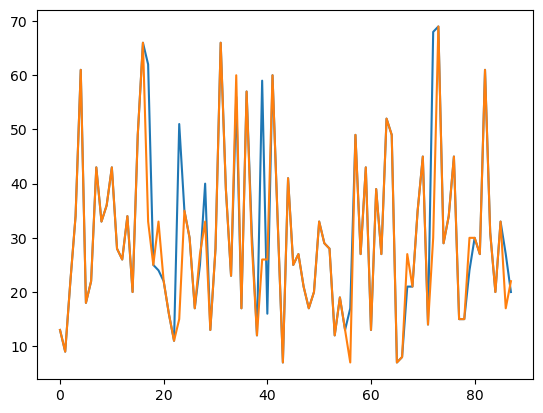

In [16]:
import matplotlib.pyplot as plt
# plt.plot(y_test.sort_index())
# plt.plot(y_pred.sort_index())
# plt.plot(y_test.values, c='tab:blue')
# plt.plot(y_pred.values, c='tab:orange')
plt.plot(y_train.values, c='tab:blue')
plt.plot(pd.Series(data=regr.predict(X_train), index=X_train.index).values, c='tab:orange')

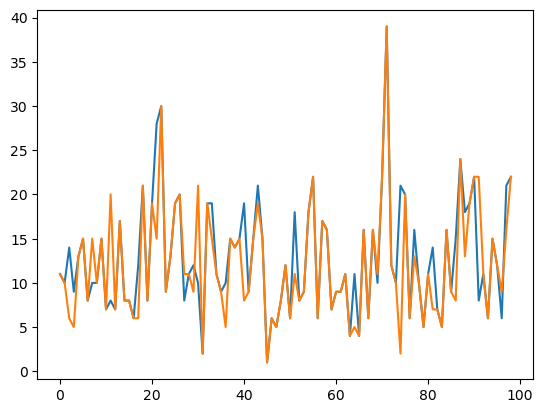

In [35]:
y_train_pred = pd.Series(data=regr.predict(X_train), index=X_train.index)
plt.plot(y_train.values, c='tab:blue')
plt.plot(y_train_pred.values, c='tab:orange')